# Modelling the glitch

With `asterion.GlitchModel`, you can model the helium-II ionization and base of the convective zone glitches given radial mode frequencies. This can be done with modelled or observed modes (with and without observational uncertainty). This notebook will go through both situations.

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpyro.distributions as dist

from asterion.models import GlitchModel, HeGlitchFunction, CZGlitchFunction, AsyFunction
from asterion.inference import Inference

from corner import corner

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Data

Import stellar evolutionary track.

In [2]:
track = pd.read_csv('data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


Choose a star from the evolutionary track.

In [3]:
profile = track.loc[1008]

Extract modes from star.

In [4]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 551.94 muHz
delta_nu ~ 35.2 muHz


In [5]:
n_max = nu_max_sca / delta_nu_fit - 1.
n_max

14.68073766060638

In [79]:
n_max = int(nu_max_sca / delta_nu_fit - 1.)

n = np.arange(n_max - 7, n_max + 7)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

Get global asteroseismic parameters.

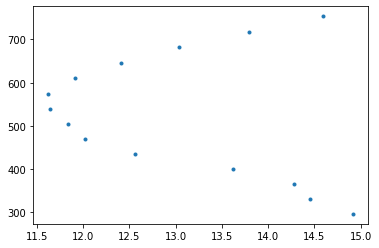

In [80]:
ax = plt.gca()
ax.plot(nu%delta_nu_fit, nu, '.');

## Model without observational error

We can create our model like this. We need to give it a prior for `delta_nu` and `nu_max`. Optionally, we can give it a prior for asymptotic fit parameters `alpha` and `epsilon`, but by default these are fairly uninformative.

In [8]:
delta_nu = (delta_nu_fit, 0.5)
nu_max = (nu_max_sca, 0.05*nu_max_sca)

In [9]:
background = AsyFunction(delta_nu)
he_glitch = HeGlitchFunction(nu_max)
cz_glitch = CZGlitchFunction(nu_max)

In [10]:
from asterion.prior import TauPrior

In [11]:
teff = dist.Uniform(4000, 7000)

In [12]:
from jax import random

key = random.PRNGKey(0)
prior = TauPrior(nu_max, teff)
tau_he, tau_cz = prior.condition(key, kind='optimized', num_samples=1000)

In [13]:
he_glitch.log_tau = tau_he
cz_glitch.log_tau = tau_cz

In [14]:
model = GlitchModel(background, he_glitch, cz_glitch)

What are our model arguments? We can check the docs for the `__call__` method of `model`. 

In [15]:
help(model.__call__)

Help on method __call__ in module asterion.models:

__call__(n: 'ArrayLike', nu_obs: 'ArrayLike' = None, nu_err: 'ArrayLike' = None, pred: 'bool' = False, num_pred: 'int' = 250) method of asterion.models.GlitchModel instance
    Sample the model for given observables.
    
    Args:
        n (:term:`array_like`): Radial order for the given modes.
        nu_obs (:term:`array_like`, optional): Observed radial mode frequencies.
        nu_err (:term:`array_like`, optional): Gaussian observational uncertainties (sigma) for nu_obs.
        pred (bool): If True, make predictions nu and nu_pred from n and num_pred.
        num_pred (int): Number of predictions in the range n.min() to n.max().



### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [16]:
infer = Inference(model, seed=42)

#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [17]:
infer.prior_predictive(model_args=(n,), model_kwargs={'pred': True})

This plot shows the prior for `nu` with the dot representing the observed value. It looks good.

In [18]:
results = infer.get_results()

In [19]:
results.data

Inference data with groups:
	> prior

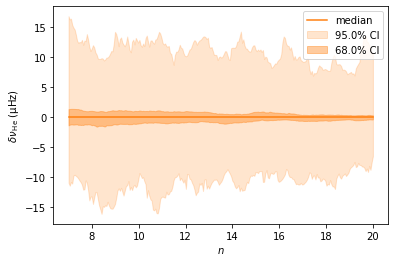

In [20]:
quantiles = [.025, .16, .84, .975]
model.plot_glitch(results.data, kind='He', group='prior', observed=False, quantiles=quantiles);

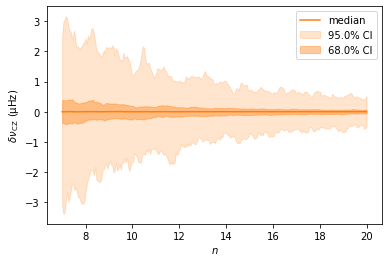

In [21]:
model.plot_glitch(results.data, kind='CZ', group='prior', observed=False, quantiles=quantiles);

#### Sample posterior

We sample from the posterior using the `numpyro` NUTS sampler. This should take about a minute.

We could do nested sampling and modify the priors for epsilon (from Gamma to LogNormal) and for phi (from VonMises to Uniform)

In [22]:
background.epsilon = dist.LogNormal(np.log(1.4), 0.4)

In [23]:
he_glitch.phi = dist.Uniform(-np.pi, np.pi)
cz_glitch.phi = dist.Uniform(-np.pi, np.pi)

In [24]:
from numpyro.contrib.nested_sampling import NestedSampler

In [59]:
ns = NestedSampler(model, sampler_name='multi_ellipsoid', num_live_points=100)
ns.run(random.PRNGKey(2), n, nu_obs=nu)

In [60]:
ns.print_summary()

--------
# likelihood evals: 39149
# samples: 2852
# likelihood evals / sample: 13.7
--------
logZ=-6.71 +- 0.37
ESS=1176


TypeError: percentile requires ndarray or scalar arguments, got <class 'list'> at position 1.

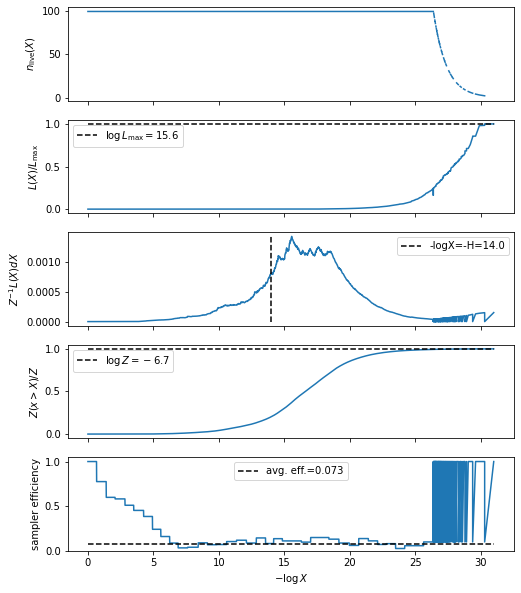

KeyboardInterrupt: 

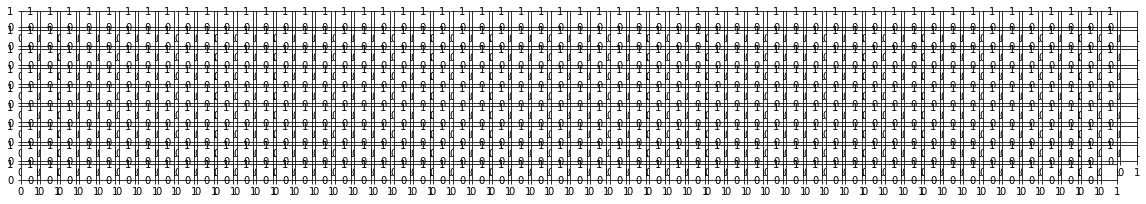

In [61]:
ns.diagnostics();

In [72]:
samples = ns.get_samples(random.PRNGKey(3), num_samples=1000)

In [73]:
for k, v in samples.items():
    samples[k] = v[None, ...]  # Add chain dimension

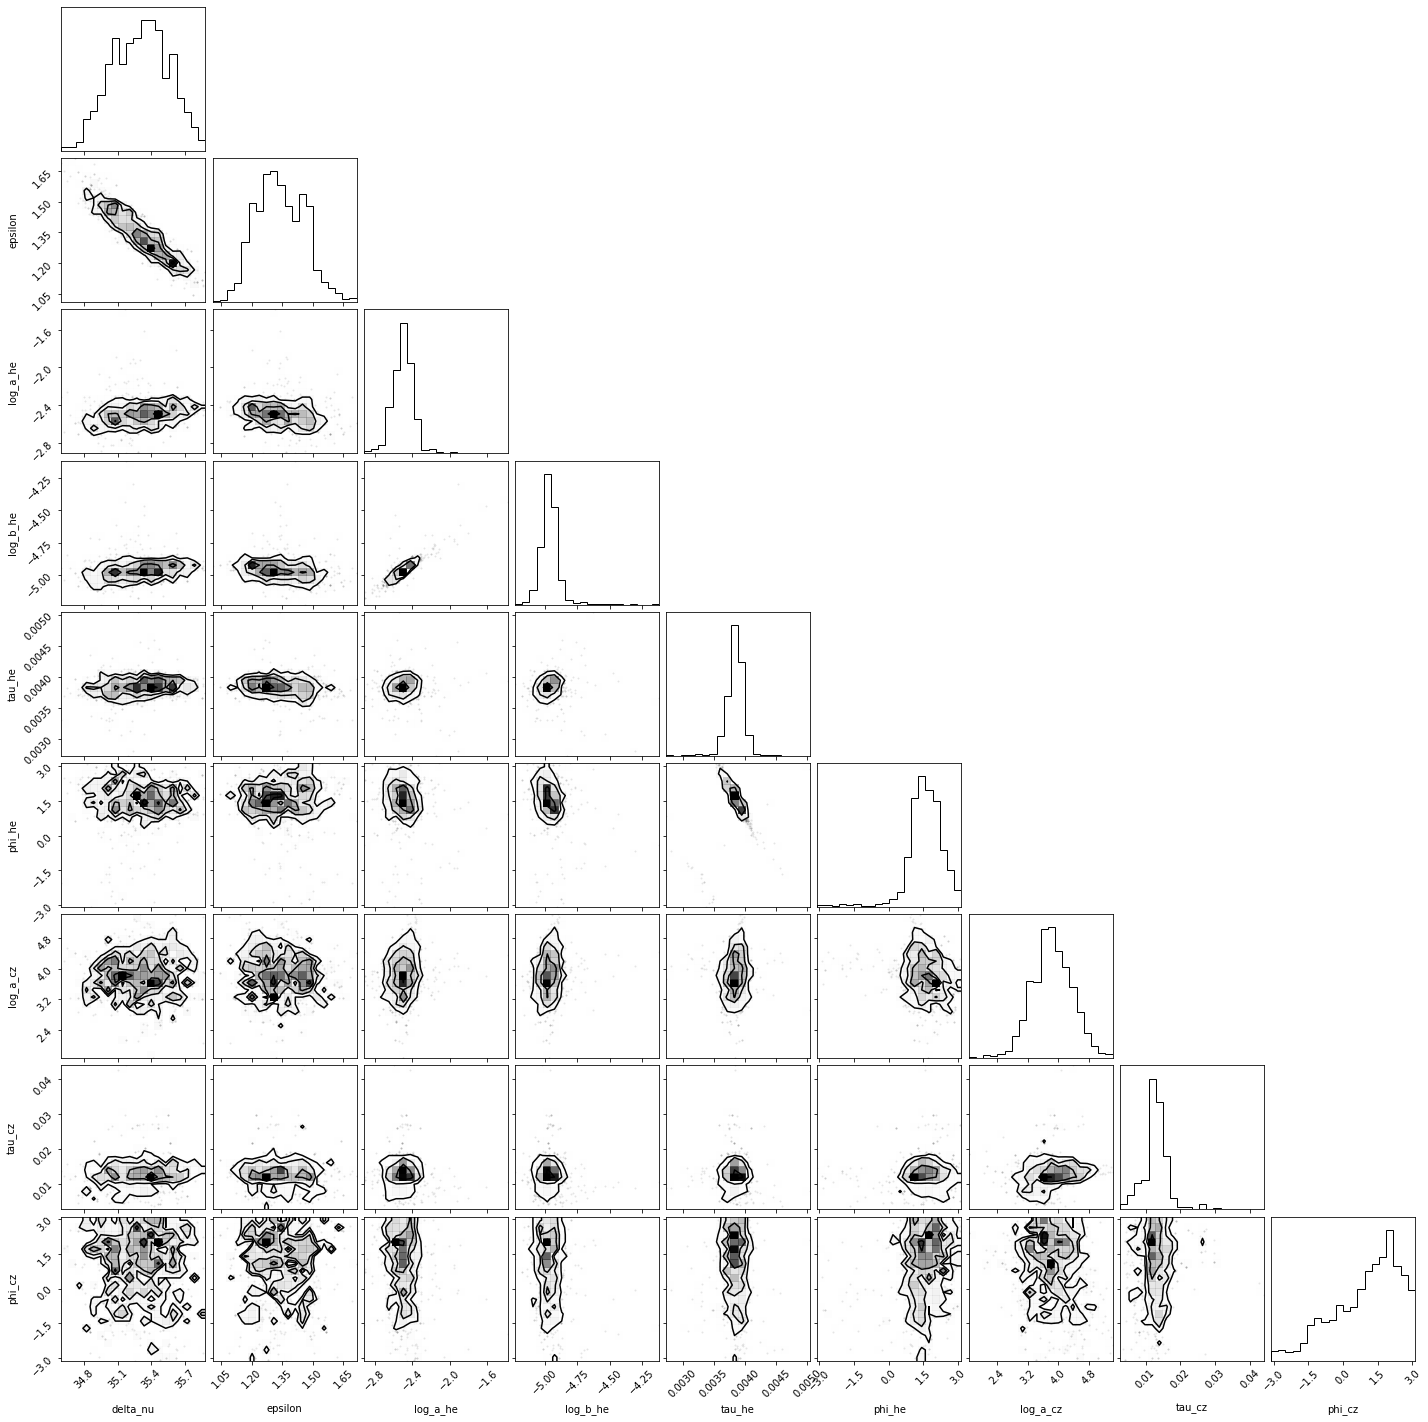

In [75]:
var_names = ['delta_nu', 'epsilon', 'log_a_he', 'log_b_he', 'tau_he', 'phi_he', 'log_a_cz', 'tau_cz', 'phi_cz']
corner(samples, var_names=var_names);

In [66]:
import numpyro

In [67]:
num_pred = 250
samples = ns.get_samples(random.PRNGKey(3), num_samples=1000)
pred = numpyro.infer.Predictive(model, samples)
p = pred(random.PRNGKey(4), n, nu_obs=nu, pred=True, num_pred=num_pred)

In [68]:
n_pred = np.linspace(n[0], n[-1], num_pred)

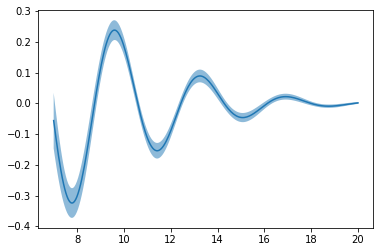

In [69]:
dnu_mean = p['dnu_he_pred'].mean(axis=0)
dnu_sd = p['dnu_he_pred'].std(axis=0)
plt.plot(n_pred, dnu_mean);
plt.fill_between(n_pred, dnu_mean-dnu_sd, dnu_mean+dnu_sd, alpha=0.5);

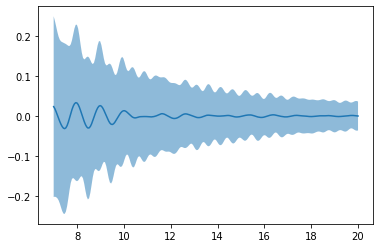

In [70]:
dnu_mean = p['dnu_cz_pred'].mean(axis=0)
dnu_sd = p['dnu_cz_pred'].std(axis=0)
plt.plot(n_pred, dnu_mean);
plt.fill_between(n_pred, dnu_mean-dnu_sd, dnu_mean+dnu_sd, alpha=0.5);

In [145]:
infer.sample(model_args=(n,), model_kwargs={'nu_obs': nu}, num_chains=5)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [146]:
infer.posterior_predictive(model_args=(n,), model_kwargs={'nu_obs': nu, 'pred': True})

In [147]:
results = infer.get_results()
results.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [ ]:
dist.VonMises()

In [148]:
10**he_glitch.log_a.mean

DeviceArray(0.00871641, dtype=float64)

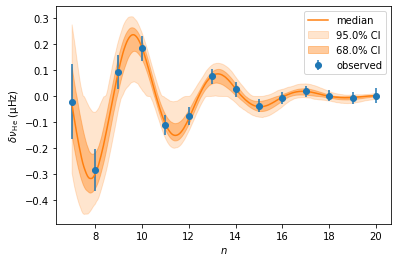

In [149]:
model.plot_glitch(results.data, kind='He', quantiles=quantiles);

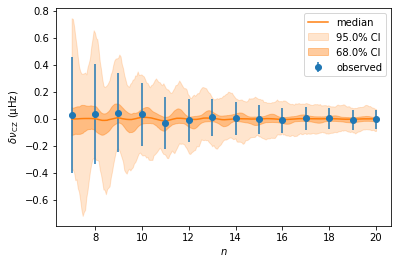

In [150]:
model.plot_glitch(results.data, kind='CZ', quantiles=quantiles);

In [151]:
results.get_var_names()

['a_cz',
 'a_he',
 'b_he',
 'delta_nu',
 'dnu_cz',
 'dnu_he',
 'epsilon',
 'log_a_cz',
 'log_a_he',
 'log_b_he',
 'log_tau_cz',
 'log_tau_he',
 'noise',
 'nu_bkg',
 'phi_cz',
 'phi_cz_unwrapped',
 'phi_he',
 'phi_he_unwrapped',
 'tau_cz',
 'tau_he']

Lets have a look at the trace plot for the model parameters.

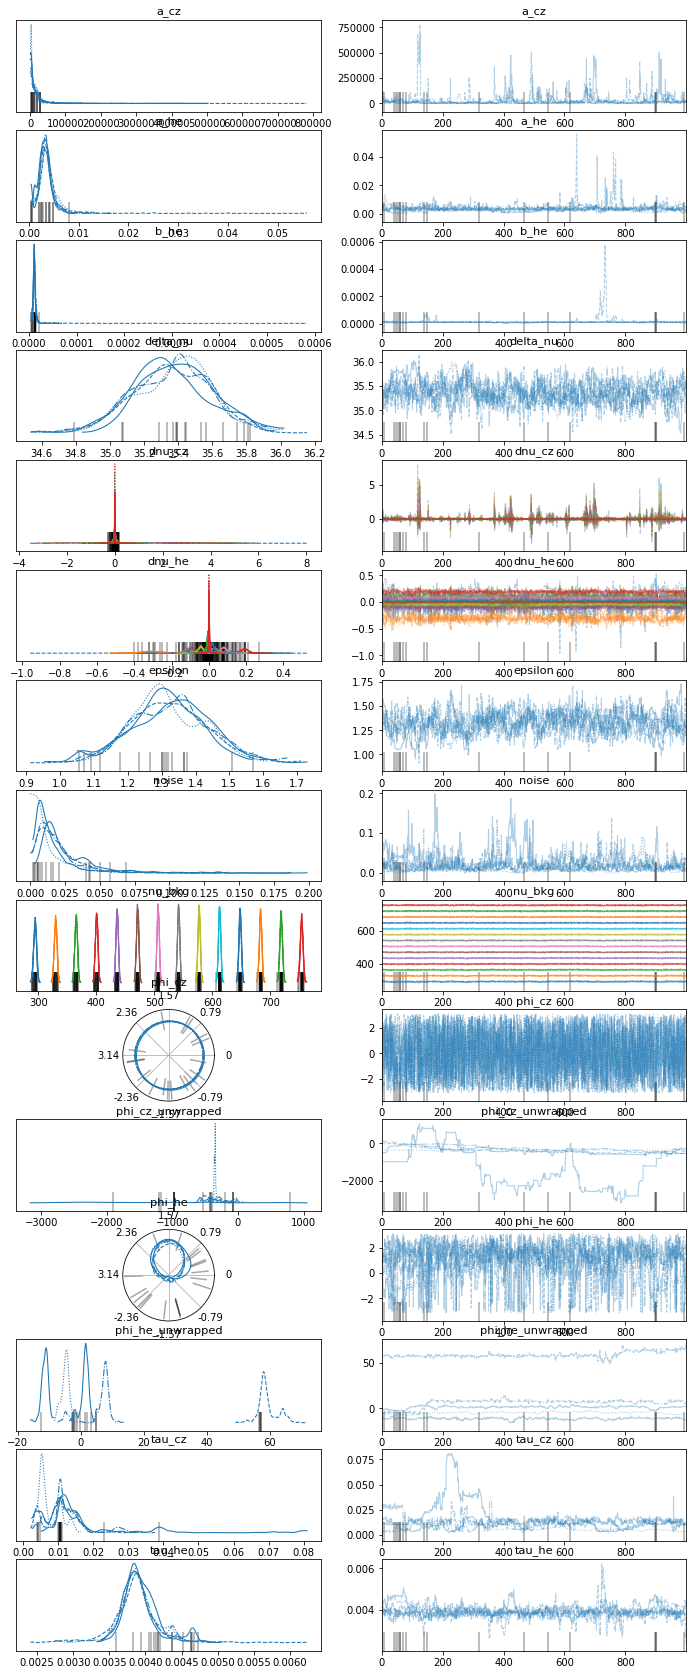

In [152]:
az.plot_trace(results.data, var_names=r'^((?!log).)*$', filter_vars='regex',
              circ_var_names=results.circ_var_names);

The data works with the `corner` module too.

In [29]:
labels = [f'{k} ({v.to_string("latex_inline")})' if str(v) != '' else k for k, v in background.units.items()]

In [35]:
background.delta_nu

In [44]:
vars(he_glitch)

{'log_a': <numpyro.distributions.continuous.Normal at 0x28a31b700>,
 'log_b': <numpyro.distributions.continuous.Normal at 0x28a1e0fd0>,
 'log_tau': <numpyro.distributions.continuous.Normal at 0x28ee3f6d0>,
 'phi': <numpyro.distributions.directional.VonMises at 0x28a336eb0>,
 'units': {'a_he': Unit(dimensionless),
  'b_he': Unit("Ms2"),
  'tau_he': Unit("Ms"),
  'phi_he': Unit("rad")}}

In [51]:
def plot_corner(model, truths=None):
    quantiles = [.16, .5, .84]
    labels = [f'{k} ({v.to_string("latex_inline")})' if str(v) != '' else k for k, v in model.units.items()]
    
    fig = corner(
        results.data, 
        var_names=list(model.units.keys()), 
        divergences=True,
        quantiles=quantiles,
        labels=labels,
        truths=truths,
    )
    return fig

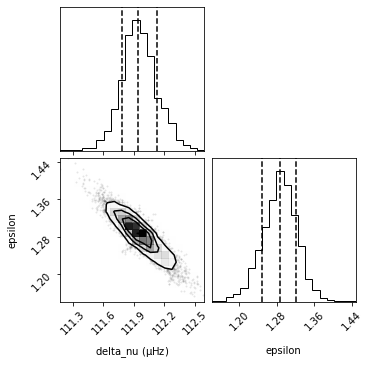

In [52]:
plot_corner(background);

In [59]:
10**he_glitch.log_b.mean

DeviceArray(3.17597715e-07, dtype=float64)

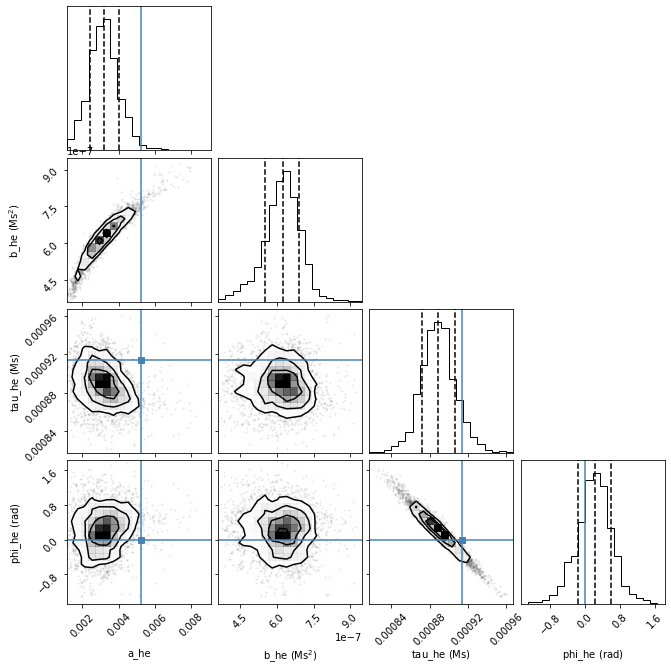

In [57]:
priors = {'a_he': 10**he_glitch.log_a.mean, 
          'b_he': 10**he_glitch.log_b.mean, 
          'tau_he': 10**he_glitch.log_tau.mean,
          'phi_he': he_glitch.phi.mean,
         }

plot_corner(he_glitch, truths=priors);

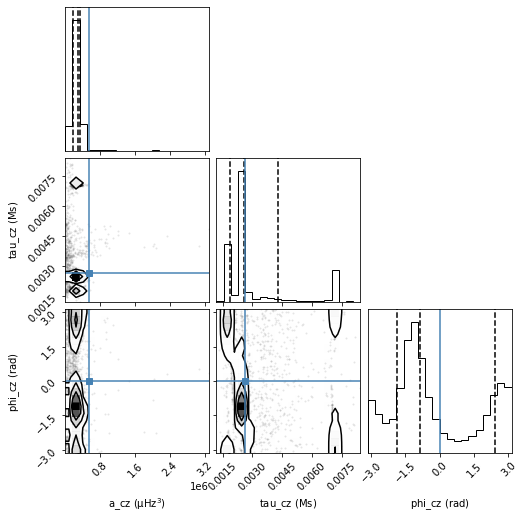

In [58]:
priors = {'a_cz': 10**cz_glitch.log_a.mean, 
          'tau_cz': 10**cz_glitch.log_tau.mean,
          'phi_cz': cz_glitch.phi.mean,
         }

plot_corner(cz_glitch, truths=priors);

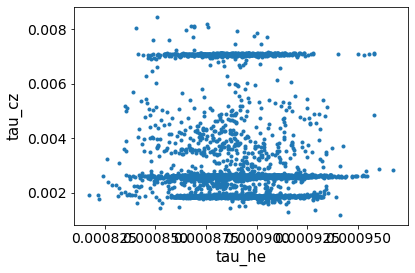

In [70]:
az.plot_pair(results.data, var_names=['tau_he', 'tau_cz']);

In [60]:
results.save('out/glitch_no_err')

PermissionError: [Errno 13] Permission denied: b'/Users/alyttle/Repos/alexlyttle/asterion/docs/source/tutorials/out/glitch_no_err/data.nc'

## Model with observational error

Synthesise observational error.

In [59]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [60]:
rng = np.random.default_rng(42)

In [61]:
def add_noise(rng, nu, nu_err):
    return rng.normal(nu, nu_err)

In [62]:
nu_obs = add_noise(rng, nu, nu_err)

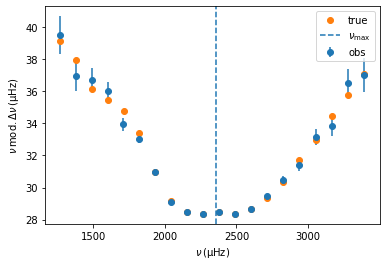

In [63]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod_obs, yerr=nu_err, fmt='o', label='obs')
ax.plot(nu, nu_mod, 'o', label='true')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [65]:
nu_err

array([1.18440898e+00, 9.55814737e-01, 7.52719145e-01, 5.72198344e-01,
       4.16434127e-01, 2.86038937e-01, 1.81007332e-01, 9.94748044e-02,
       4.17027255e-02, 8.55565859e-03, 3.78361795e-04, 1.72087208e-02,
       5.92086931e-02, 1.26606938e-01, 2.19686184e-01, 3.38567162e-01,
       4.82994170e-01, 6.53421847e-01, 8.49161061e-01, 1.07041305e+00])

In [67]:
infer.sample(model_args=(n,), model_kwargs={'nu_obs': nu_obs, 'nu_err': nu_err}, num_chains=5)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [68]:
infer.posterior_predictive(model_args=(n,), model_kwargs={'nu_obs': nu_obs, 'nu_err': nu_err, 'pred': True})

In [69]:
results = infer.get_results()
results.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

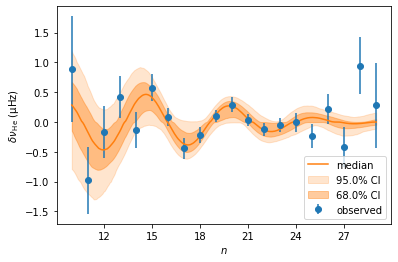

In [72]:
quantiles = [.025, .16, .84, .975]
model.plot_glitch(results.data, kind='He', quantiles=quantiles);

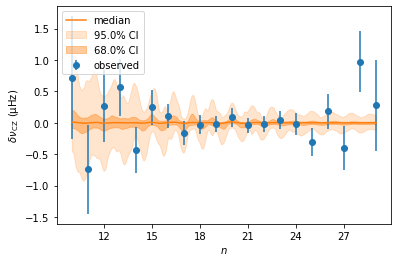

In [73]:
model.plot_glitch(results.data, kind='CZ', quantiles=quantiles);

Lets have a look at the trace plot for the model parameters.

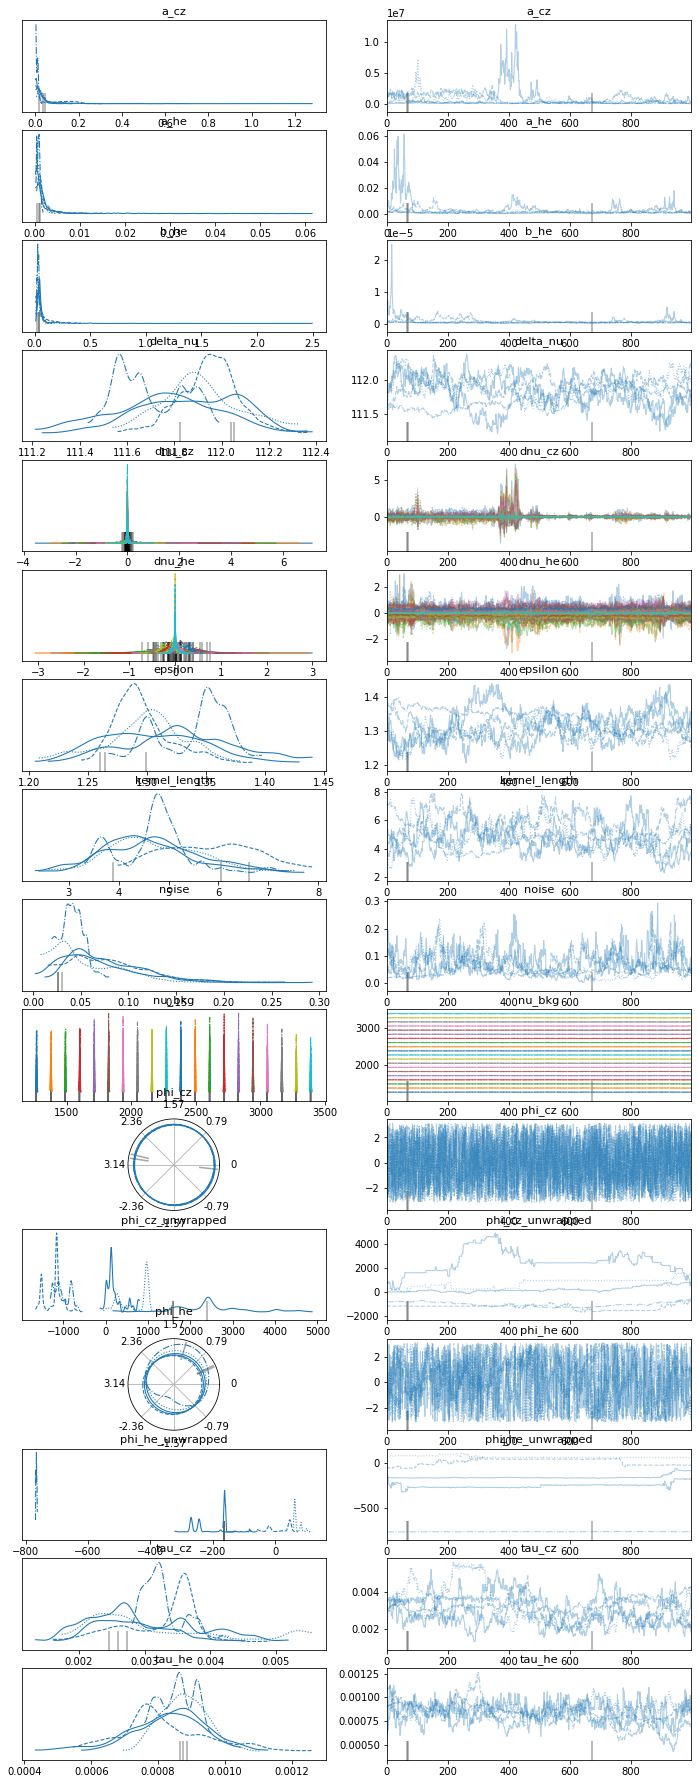

In [75]:
az.plot_trace(results.data, var_names=r'^((?!log).)*$', filter_vars='regex',
              circ_var_names=results.circ_var_names);

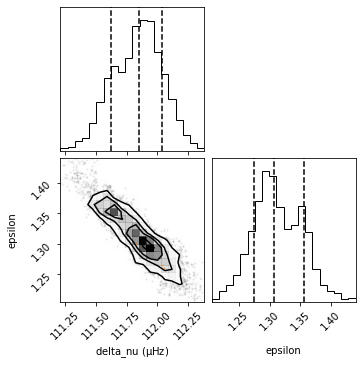

In [76]:
plot_corner(background);

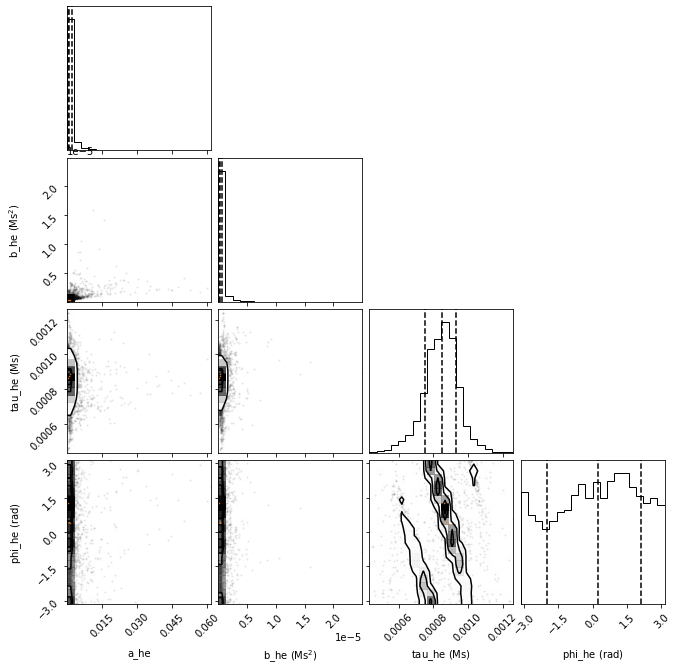

In [77]:
plot_corner(he_glitch);

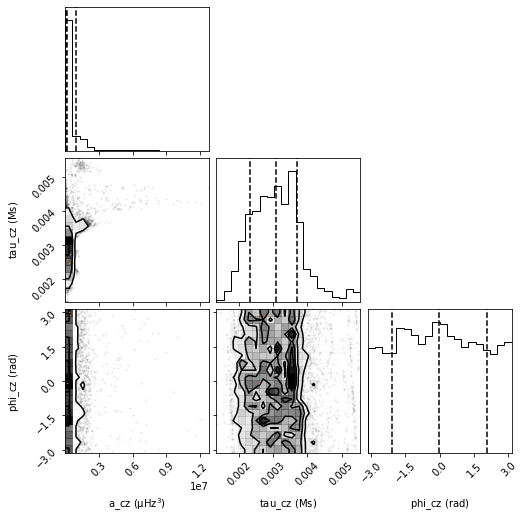

In [78]:
plot_corner(cz_glitch);

In [79]:
results.save('out/glitch_with_err')